# Get Embeddings Metadata Exploration

In [1]:
"""Get Embeddings Metadata Exploration

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Plot 
"""

# 1. Imports, Variables, Functions
# imports
import pickle, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import anndata as ad, os, sys
from tqdm import tqdm
# variables
pp_data = "pp_data-24-09-04-01"

metadata_path = '../data/%s/metadata.pkl'%pp_data
adata_path = '../data/%s/data.h5ad'%pp_data
output_dir = "../data/%s/data_analysis/"%pp_data

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# functions
def get_diseases_with_n_datasets(obs:pd.DataFrame, n:int)->set:
    validation_diseases = set()
    for disease in tqdm(obs["disease_study"].unique()):
        QUERY = "disease == @disease"
        _df_query = obs.query(QUERY)
        

        if _df_query["dataset"].nunique() >= n:
            validation_diseases.add(disease)

    return validation_diseases
        

# 2. Load Data
with open(metadata_path,"rb") as f:
    metadata = pickle.load(f)

adata = ad.read_h5ad(adata_path, backed='r') # parameters: backed='r' to read from disk

# Access other attributes without loading adata.X
obs = adata.obs

# 3. Plot 
# get how many datasets, de signatures, control and disease samples

print('REPORT FOR FILTER 1 HUMAN & RNA-SEQ, MICROARRAY ')
print('Number of datasets:', obs["dataset"].nunique())
print('Number of DE signatures:', len(set([id.split(";")[0] for id in obs["ids"]])))
print('Number of diseases:', obs["disease_study"].nunique())
print('Number of control samples:', len([id.split(";")[2] for id in obs["ids"] if id.split(";")[2] == 'Control']))
print('Number of disease samples:', len([id.split(";")[2] for id in obs["ids"] if id.split(";")[2] != 'Control']))
print('Number of diseases w/ 5+ datasets:', len(get_diseases_with_n_datasets(obs, 5)))

# filter by nº of non-nan gene values per sample
threshold = 10000   # at least 10k non-nan gene values per sample

filter_2 = metadata["n_non_nan_gex"]>10000

obs_f2 = obs[filter_2]

print('REPORT FOR FILTER 2 10k NON-NAN GENE VALUES')
print('Number of datasets:', obs_f2["dataset"].nunique())
print('Number of DE signatures:', len(set([id.split(";")[0] for id in obs_f2["ids"]])))
print('Number of diseases:', obs_f2["disease_study"].nunique())
print('Number of control samples:', len([id.split(";")[2] for id in obs_f2["ids"] if id.split(";")[2] == 'Control']))
print('Number of disease samples:', len([id.split(";")[2] for id in obs_f2["ids"] if id.split(";")[2] != 'Control']))
print('Number of diseases w/ 5+ datasets:', len(get_diseases_with_n_datasets(obs_f2, 5)))


df_results = pd.DataFrame(
    {"Filtering":["Human & RNA-Seq or Microarray",">=10k Protein Coding Genes"],
     "Nº Datasets":[obs["dataset"].nunique(),obs_f2["dataset"].nunique()],
     "Nº Diseases":[obs["disease_study"].nunique(),obs_f2["disease_study"].nunique()],
     "Nº Diseases 5+ Datasets":[len(get_diseases_with_n_datasets(obs, 5)),len(get_diseases_with_n_datasets(obs_f2, 5))],
     "Nº Control Samples":[len([id.split(";")[2] for id in obs["ids"] if id.split(";")[2] == 'Control']), len([id.split(";")[2] for id in obs_f2["ids"] if id.split(";")[2] == 'Control'])],
     "Nº Disease Samples":[len([id.split(";")[2] for id in obs["ids"] if id.split(";")[2] != 'Control']),len([id.split(";")[2] for id in obs_f2["ids"] if id.split(";")[2] != 'Control'])],
     "Nº DE Signatures":[len(set([id.split(";")[0] for id in obs["ids"]])),len(set([id.split(";")[0] for id in obs_f2["ids"]]))],
     }
)

df_results

REPORT FOR FILTER 1 HUMAN & RNA-SEQ, MICROARRAY 
Number of datasets: 1131
Number of DE signatures: 2218
Number of diseases: 30
Number of control samples: 29471
Number of disease samples: 37505


100%|██████████| 30/30 [00:00<00:00, 645.45it/s]


Number of diseases w/ 5+ datasets: 29
REPORT FOR FILTER 2 10k NON-NAN GENE VALUES
Number of datasets: 1070
Number of DE signatures: 2113
Number of diseases: 30
Number of control samples: 28275
Number of disease samples: 35207


100%|██████████| 30/30 [00:00<00:00, 647.56it/s]


Number of diseases w/ 5+ datasets: 29


100%|██████████| 30/30 [00:00<00:00, 685.36it/s]


,Filtering,Nº Datasets,Nº Diseases,Nº Diseases 5+ Datasets,Nº Control Samples,Nº Disease Samples,Nº DE Signatures
0,Human & RNA-Seq or Microarray,1131,30,29,29471,37505,2218
1,>=10k Protein Coding Genes,1070,30,29,28275,35207,2113


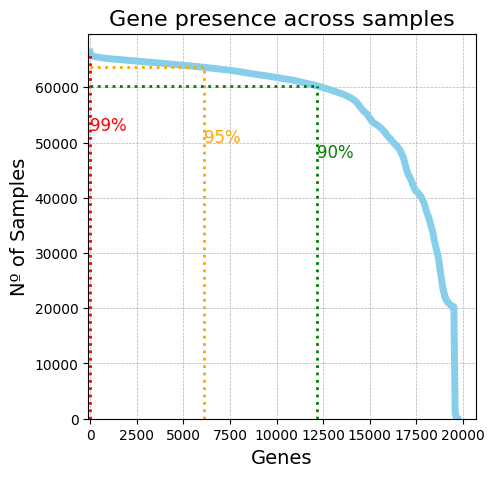

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# sort data
metadata['n_non_nan_genes'].sort()


# Sample data for demonstration
x = list(range(len(metadata['n_non_nan_genes'])))
y = metadata['n_non_nan_genes'][::-1]

# Convert to a line plot
plt.figure(figsize=(5,5))
plt.plot(x, y, color='skyblue', label='Number of non-NaN genes', linewidth=5)

# Calculate thresholds
thresholds = [0.99, 0.95, 0.90]
colors = ['red', 'orange', 'green']

for i, threshold in enumerate(thresholds):
    
    threshold_value = metadata["n_gex"] * threshold
    
    # Find the index where y meets or exceeds the threshold
    indices = np.where(y >= threshold_value)[0]

    if len(indices) == 0:
        threshold_index = -1
    else:
        threshold_index = indices[-1]

    plt.hlines(threshold_value, 0, threshold_index, color=colors[i], linestyles="dotted", linewidth=2)
    plt.vlines(threshold_index, 0, threshold_value, color=colors[i], linestyles="dotted", linewidth=2)
        
    # Annotate the vertical line, adjust position dynamically if needed
    plt.text(threshold_index + 1, threshold_value * 0.8, f'{int(threshold * 100)}%', 
                color=colors[i], fontsize=12, va='center')

# Add a title and labels
plt.title('Gene presence across samples', fontsize=16)
plt.xlabel('Genes', fontsize=14)
plt.ylabel('Nº of Samples', fontsize=14)

# Add a legend
# plt.legend()

# Add lim
plt.ylim(0,)
plt.xlim(-100,)


# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.savefig(os.path.join(output_dir, 'gene_presence.png'), dpi=300, bbox_inches='tight')


5
6111
12149


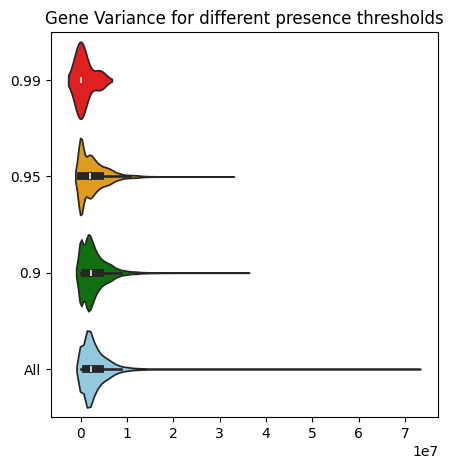

In [3]:
import seaborn as sns
thresholds = [0.99, 0.95, 0.90]

data = dict()
for i in thresholds:
    threshold_value = metadata["n_gex"] * i
    mask = metadata['n_non_nan_genes'] >= threshold_value
    values = metadata['genes_std'][mask]
    values = values[~np.isnan(values)]
    data[i] = values
    print(len(values))


data["All"] = metadata['genes_std'][~np.isnan(metadata['genes_std'])]

# plot gene variance
plt.figure(figsize=(5,5))
plt.title("Gene Variance for different presence thresholds")
sns.violinplot(data=data, orient='h',palette=['red', 'orange', 'green','skyblue'])

plt.savefig(os.path.join(output_dir, 'gene_variance.png'), dpi=300, bbox_inches='tight')


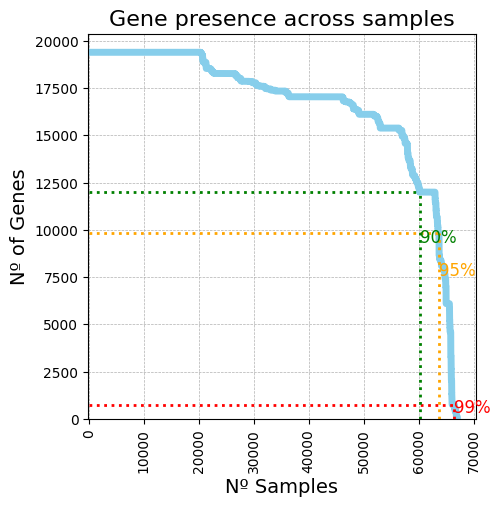

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# sort data
metadata['n_non_nan_gex'].sort()


# Sample data for demonstration
x = np.array(list(range(len(metadata['n_non_nan_gex']))))
y = metadata['n_non_nan_gex'][::-1]

# Convert to a line plot
plt.figure(figsize=(5,5))
plt.plot(x, y, color='skyblue', label='Number of non-NaN genes', linewidth=5)

# Calculate thresholds
thresholds = [0.99, 0.95, 0.90]
colors = ['red', 'orange', 'green']


for i, threshold in enumerate(thresholds):
    
    x_value = int(metadata["n_gex"] * threshold)
    y_value_idx = np.argwhere(x >= x_value)[0][0]
    y_value = y[y_value_idx]
    
    plt.vlines(x_value, 0, y_value, color=colors[i], linestyles="dotted", linewidth=2)
    plt.hlines(y_value, 0, x_value, color=colors[i], linestyles="dotted", linewidth=2)
    
    plt.text(x_value + 1, y_value * 0.8, f'{int(threshold * 100)}%', 
            color=colors[i], fontsize=12, va='center')


# for i, threshold in enumerate(thresholds):
    
#     threshold_value = metadata["n_genes"] * threshold
#     plt.hlines(threshold_value, 0, len(metadata['n_non_nan_gex']), color=colors[i], linestyles="dotted", linewidth=2)
    
#     # Find the index where y meets or exceeds the threshold
#     indices = np.where(y >= threshold_value)[0]

#     if len(indices) == 0:
#         threshold_index = -1
#     else:
#         threshold_index = indices[-1]
#     plt.vlines(threshold_index, 0, threshold_value, color=colors[i], linestyles="dotted", linewidth=2)
        
#     # Annotate the vertical line, adjust position dynamically if needed
#     plt.text(threshold_index + 1, threshold_value * 0.8, f'{int(threshold * 100)}%', 
#                 color=colors[i], fontsize=12, va='center')

# Add a title and labels
plt.title('Gene presence across samples', fontsize=16)
plt.xlabel('Nº Samples', fontsize=14)
plt.ylabel('Nº of Genes', fontsize=14)

# Add a legend
# plt.legend()

# Add lim
plt.ylim(0,)
plt.xlim(-100,)

plt.xticks(rotation=90)


# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.savefig(os.path.join(output_dir, 'sample_presence.png'), dpi=300, bbox_inches='tight')
